## Data import and cleanup

### Import dependencies

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

### Fetch data 

In [2]:
flight_df = pd.read_excel('Data_Train.xlsx')
flight_df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


### Missing Values

In [3]:
flight_df.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64

### Replace missing value in total stops with mode

In [4]:
flight_df['Total_Stops'] = flight_df['Total_Stops'].fillna(flight_df['Total_Stops'].mode()[0])

### Drop route and additional info (redundant) column

In [5]:
flight_df.drop(columns=['Route','Additional_Info','Dep_Time','Arrival_Time'],axis=1,inplace=True)

## Dealing with categorical variables

### Split Date, Month and year of Journey

In [6]:
flight_df['Date'] = flight_df['Date_of_Journey'].str.split("/").str[0].astype(int)
flight_df['Month'] = flight_df['Date_of_Journey'].str.split("/").str[1].astype(int)
flight_df['Year'] = flight_df['Date_of_Journey'].str.split("/").str[2].astype(int)
flight_df.drop(columns='Date_of_Journey',axis=1,inplace=True)

### Check year redundancy and dropping it

In [7]:
flight_df.drop(columns='Year',axis=1,inplace=True)

### Convert Total stops to integer

In [8]:
stops_list = flight_df['Total_Stops'].unique().tolist()
stops_list.sort()
print(stops_list)

['1 stop', '2 stops', '3 stops', '4 stops', 'non-stop']


In [9]:
flight_df['Total_Stops'] = flight_df['Total_Stops'].str.replace('1 stop','1')
flight_df['Total_Stops'] = flight_df['Total_Stops'].str.replace('2 stops','2')
flight_df['Total_Stops'] = flight_df['Total_Stops'].str.replace('3 stops','3')
flight_df['Total_Stops'] = flight_df['Total_Stops'].str.replace('4 stops','4')
flight_df['Total_Stops'] = flight_df['Total_Stops'].str.replace('non-stop','0')
flight_df['Total_Stops'] = flight_df['Total_Stops'].astype(int)
flight_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Airline      10683 non-null  object
 1   Source       10683 non-null  object
 2   Destination  10683 non-null  object
 3   Duration     10683 non-null  object
 4   Total_Stops  10683 non-null  int32 
 5   Price        10683 non-null  int64 
 6   Date         10683 non-null  int32 
 7   Month        10683 non-null  int32 
dtypes: int32(3), int64(1), object(4)
memory usage: 542.6+ KB


### Convert duration to integer

In [10]:
# Replace h and m 
flight_df['Hours'] = flight_df['Duration'].str.split(' ').str[0].str.replace('h','')
flight_df['Minutes'] = flight_df['Duration'].str.split(' ').str[1].str.replace('m','')

# Find inappropriate values and dropping it
flight_df.loc[flight_df['Hours'].str.contains('[A-Za-z]')]
row_drop = flight_df.loc[flight_df['Hours'].str.contains('[A-Za-z]')].index
flight_df.drop(index = row_drop,inplace=True)

# Replace NAN values
flight_df['Minutes'].fillna("0",inplace=True)

# Convert hours and minutes to integer
flight_df['Hours'] = flight_df['Hours'].astype(int)
flight_df['Minutes'] = flight_df['Minutes'].astype(int)

# Update duration based on hours and minutes
flight_df['Duration'] = flight_df['Hours']*60 + flight_df['Minutes']

# Drop Hours and Minutes
flight_df.drop(columns=['Hours','Minutes'],axis=1)

C:\Users\srajend7\AppData\Local\Temp\ipykernel_21792\1739961459.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  flight_df['Minutes'].fillna("0",inplace=True)


,Airline,Source,Destination,Duration,Total_Stops,Price,Date,Month
0,IndiGo,Banglore,New Delhi,170,0,3897,24,3
1,Air India,Kolkata,Banglore,445,2,7662,1,5
2,Jet Airways,Delhi,Cochin,1140,2,13882,9,6
3,IndiGo,Kolkata,Banglore,325,1,6218,12,5
4,IndiGo,Banglore,New Delhi,285,1,13302,1,3
...,...,...,...,...,...,...,...,...
10678,Air Asia,Kolkata,Banglore,150,0,4107,9,4
10679,Air India,Kolkata,Banglore,155,0,4145,27,4
10680,Jet Airways,Banglore,Delhi,180,0,7229,27,4
10681,Vistara,Banglore,New Delhi,160,0,12648,1,3


### Label Encoding - Airline,Source and Destination

In [11]:
# Moving Airline names to a new data frame for EDA
new_df = flight_df['Airline'].to_frame()

In [12]:
lec = LabelEncoder()
flight_df['Airline_encoded']=lec.fit_transform(flight_df['Airline'])

lec2 = LabelEncoder()
flight_df['Source']=lec2.fit_transform(flight_df['Source'])

lec3 = LabelEncoder()
flight_df['Destination']=lec3.fit_transform(flight_df['Destination'])
flight_df.head()

flight_df.drop(columns='Airline',axis =1)

,Source,Destination,Duration,Total_Stops,Price,Date,Month,Hours,Minutes,Airline_encoded
0,0,5,170,0,3897,24,3,2,50,3
1,3,0,445,2,7662,1,5,7,25,1
2,2,1,1140,2,13882,9,6,19,0,4
3,3,0,325,1,6218,12,5,5,25,3
4,0,5,285,1,13302,1,3,4,45,3
...,...,...,...,...,...,...,...,...,...,...
10678,3,0,150,0,4107,9,4,2,30,0
10679,3,0,155,0,4145,27,4,2,35,1
10680,0,2,180,0,7229,27,4,3,0,4
10681,0,5,160,0,12648,1,3,2,40,10


## Exploratory Data Analysis

### Most preferred flights 

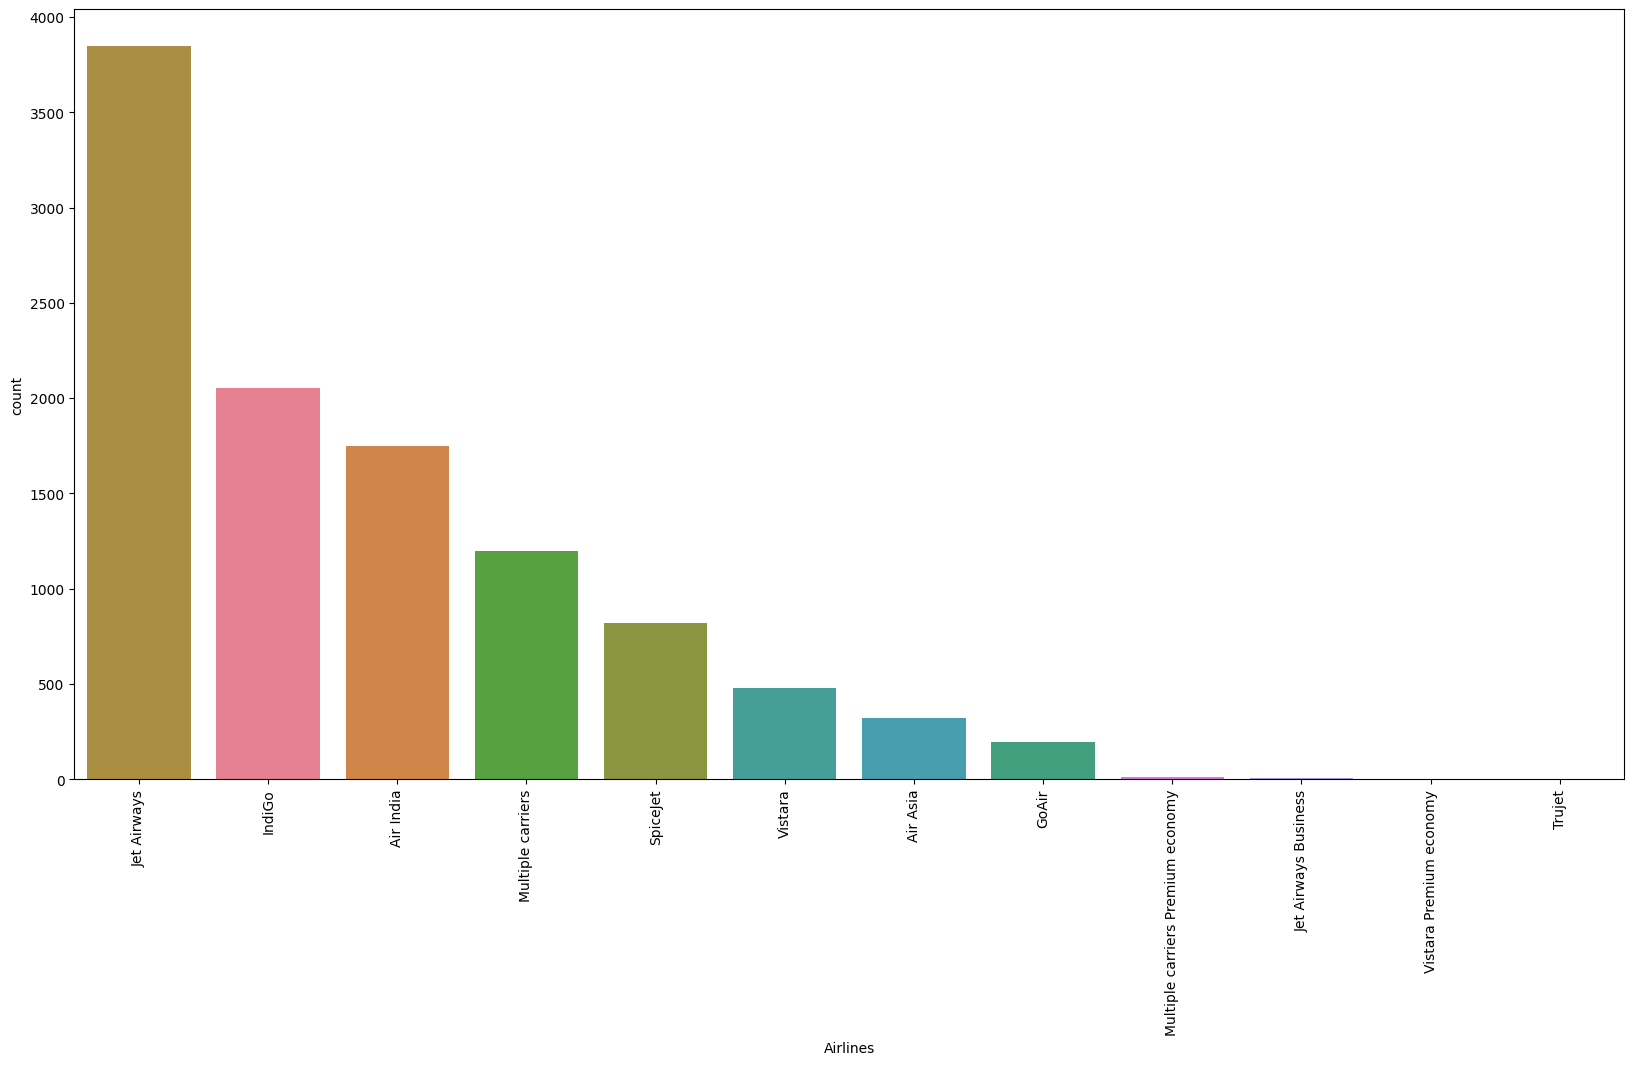

In [13]:
plt.figure(figsize=(20,10))
sns.countplot(data=flight_df,x=new_df['Airline'],order=flight_df['Airline'].value_counts().index,hue=new_df['Airline'])
plt.xlabel('Airlines')
plt.xticks(rotation=90)
plt.show()

### Most Costly flights

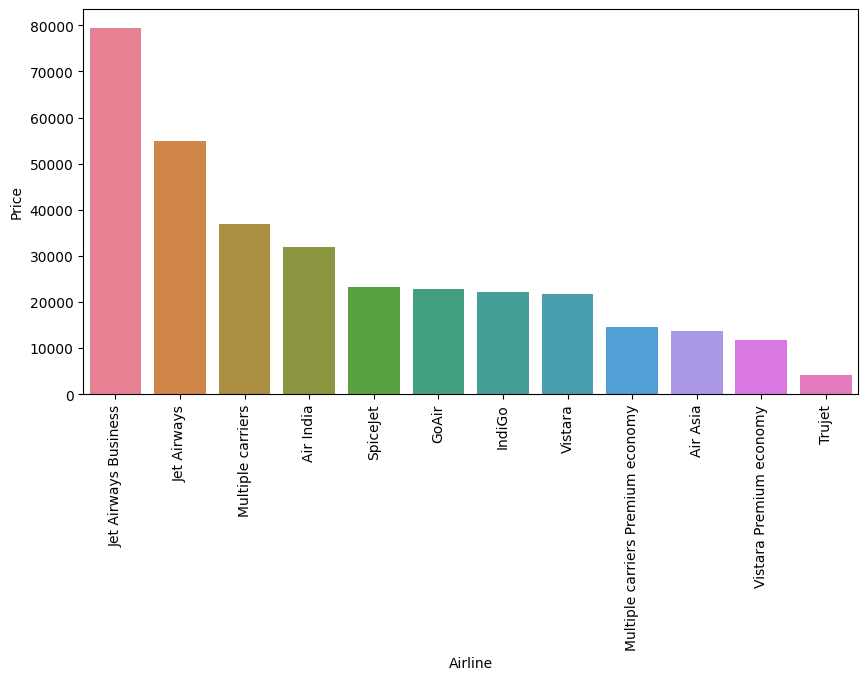

In [14]:
plt.figure(figsize=(10,5))
Y = flight_df.groupby('Airline')['Price'].max()
Y_sorted = Y.sort_values(ascending=False)
X_sorted = Y_sorted.index
sns.barplot(x=X_sorted,y=Y_sorted,hue=X_sorted)
plt.xticks(rotation=90)
plt.show()

## ML process

### Load an instance of regression models 

In [15]:
KNN = KNeighborsRegressor()
DT = DecisionTreeRegressor()
RF = RandomForestRegressor()
XGB = XGBRegressor()

### Segregating X and Y variables

In [16]:
flight_df.drop(columns='Airline',axis=1,inplace=True)

In [17]:
# Split depedent and independent variables
X = flight_df[[col for col in flight_df.columns if col != 'Price']]
Y = flight_df['Price']

### Train test split

In [18]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2,random_state=42)

### Training ML models - Train test split 

In [19]:
ML_models = [KNN,DT,RF,XGB]
tt_result_data = []
for model in ML_models:
    print('--------------Training ',type(model).__name__,'----------------------------')
    model.fit(X_train,Y_train)
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    mae_train = mean_absolute_error(train_pred,Y_train)
    mae_test = mean_absolute_error(test_pred,Y_test)
    r_score_train = r2_score(train_pred,Y_train)
    r_score_test = r2_score(test_pred,Y_test)
    print('mae_train_accuracy ',mae_train)
    print('mae_test_accuracy', mae_test)
    print('r_score_train ',r_score_train)
    print('r_score_test ',r_score_test)
    tt_result_data.append({'Model': type(model).__name__,'r_score_test': r_score_test})

--------------Training  KNeighborsRegressor ----------------------------
mae_train_accuracy  1600.5814862492687
mae_test_accuracy 2021.0326626111375
r_score_train  0.4998961321935438
r_score_test  0.2317243419618149
--------------Training  DecisionTreeRegressor ----------------------------
mae_train_accuracy  479.1545725388323
mae_test_accuracy 1539.8511098141187
r_score_train  0.9372462583616417
r_score_test  0.6390485817552849
--------------Training  RandomForestRegressor ----------------------------
mae_train_accuracy  709.5050118060478
mae_test_accuracy 1343.5884637391455
r_score_train  0.9149725732247814
r_score_test  0.7284642564364503
--------------Training  XGBRegressor ----------------------------
mae_train_accuracy  953.7700820021074
mae_test_accuracy 1266.4195922223219
r_score_train  0.8817793726921082
r_score_test  0.7793614864349365


### Training ML models - CV score

In [21]:
ML_models = [KNN,DT,RF,XGB]
cv_result_data = []
for model in ML_models:
    print('--------------Training ',type(model).__name__,'----------------------------')
    rst = cross_val_score(estimator= model,X=X,y=Y,cv=10)
    final_rst = np.mean(rst)
    print(final_rst)
    cv_result_data.append({'cv_score': final_rst})   

--------------Training  KNeighborsRegressor ----------------------------
0.5347291318456797
--------------Training  DecisionTreeRegressor ----------------------------
0.65728261109195
--------------Training  RandomForestRegressor ----------------------------
0.7665087790408472
--------------Training  XGBRegressor ----------------------------
0.8118321120738983


### Training ML model - Kfold

In [22]:
kf_result_data =[]
kf = KFold(n_splits=10,shuffle=True,random_state=42)
X = X.reset_index(drop=True)
Y = Y.reset_index(drop=True)
for model in ML_models:
    print('--------------Training ',type(model).__name__,'----------------------------')
    for train_index,test_index in kf.split(X):
        X_train,X_test = X.iloc[train_index],X.iloc[test_index]
        Y_train,Y_test = Y.iloc[train_index],Y.iloc[test_index]
        model.fit(X_train,Y_train)
        train_pred = model.predict(X_train)
        test_pred = model.predict(X_test)
        mae_train = mean_absolute_error(train_pred,Y_train)
        mae_test = mean_absolute_error(test_pred,Y_test)
        r_score_train = r2_score(train_pred,Y_train)
        r_score_test = r2_score(test_pred,Y_test)
    kf_result_data.append({'K_r_score_test': np.mean(r_score_test)})

--------------Training  KNeighborsRegressor ----------------------------
--------------Training  DecisionTreeRegressor ----------------------------
--------------Training  RandomForestRegressor ----------------------------
--------------Training  XGBRegressor ----------------------------


### Result data frame

In [24]:
df1 = pd.DataFrame(tt_result_data)
df2 = pd.DataFrame(cv_result_data)
df3 = pd.DataFrame(kf_result_data)
final_df = pd.concat([df1,df2,df3],axis=1)
final_df

,Model,r_score_test,cv_score,K_r_score_test
0,KNeighborsRegressor,0.231724,0.534729,0.383697
1,DecisionTreeRegressor,0.639049,0.657283,0.728452
2,RandomForestRegressor,0.728464,0.766509,0.783237
3,XGBRegressor,0.779361,0.811832,0.832428
